__File: srg_observables_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     August 28, 2019__

This notebook creates a few figures showing phase shifts and momentum distributions from NN potentials for initial or SRG-evolved potentials. Each function creates and saves a figure to the __Figures/SRG_observables__ folder. Below is an outline of each function:
* phase_shifts - Plots NN phase shifts from several potentials.
* deuteron_momentum_distribution - Plots deuteron momentum distributions comparing initial and SRG-evolved $\psi^2$. Note this depicts $\psi(s)^2$ not $|\psi(s)|^2 = \psi^{\dagger}(0) U^{\dagger}(s) U(s) \psi(0) = |\psi(0)|^2$.
* continuum_state_distribution - Analog of the deuteron_momentum_distribution function but for some state $\epsilon_k$ > 0 MeV.
* energies_from_truncated_hamiltonian - Compares the bound state energies of an initial Hamiltonian and an evolved Hamiltonian truncated up to some value in momentum.

__Revision history:<br/>__
* August 30, 2019 - Finalized phase_shifts, deuteron_momentum_distribution, and continuum_state_distribution functions.
* September 5, 2019 - Generalized functional arguments. This is helpful for plotting several curves on the same figure.
* September 9, 2019 - Generalized phase_shifts and continuum_state_momentum_distribution to plot for any partial wave channel.
* September 20, 2019 - Added energies_from_truncated_hamiltonian function.

In [1]:
from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
import observables as ob
import operators as op
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Plotting functions__

In [2]:
def phase_shifts(channel, *potentials):
    """
    Plots NN phase shifts [deg] with respect to momentum [fm^-1] for different potentials.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    *potentials : tuple
        Specifications for phase shifts of an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) 
        is the number specifying the potential, kmax (float) is the maximum value in the momentum mesh, kmid (float)
        is the mid-point value in the mesh, and ntot (int) is the number of points in the mesh. For example, 
        (10, 30.0, 4.0, 120) corresponds to the Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name = phase_shifts_ with an extension based off the given arguments. For example,
                phase_shifts_3S1_kvnns_10_106_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47    

    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Relative momentum in fm^-1
    k_max = 4.0
    M = 200 # Number of points in array
    k_points = np.linspace(0.01, k_max, M)
    # We could also plot phase shifts w.r.t to E_lab but we choose k for comparison to potential matrix elements
    # in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # x-axis limits
    xlim = [0.0, k_max]
     
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 4.5*width
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 5*height
    legend_label_size = 3.5*width
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 5.5*width
    
    # Things which depend on the channel: y-axis limits and some label locations
    if channel == '1S0':
        ylim = [-80.0, 70.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    elif channel == '3S1':
        ylim = [-40.0, 180.0]
        legend_label_location = 'upper right'
        channel_label_location = 'lower left'
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper center'
    else:
        ylim = [-40.0, 180.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    
    # Initialize file name of figure
    file_name = 'phase_shifts_%s_' % channel + 'kvnns' # This reads 'phase_shifts_3S1_kvnns_'
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4)) 
    
    # Loop over specifications keeping track of the curve number i
    i = 0
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i) # Color
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.kvnn_label_conversion(kvnn) # Legend label
        
        # Add to figure
        ax.plot(k_points, delta_array, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add channel as anchored text
    anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size), loc=channel_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def deuteron_momentum_distribution(ax, kvnn, kmax, kmid, ntot, lamb, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a semi-log figure.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *srg : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name = deuteron_momentum_distribution_ with an extension based off the given arguments. For example,
                deuteron_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 14
    lambda_label_size = 14
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # Initialize file name of figure
    # This reads 'deuteron_momentum_distribution_kvnn##_' where ## is an integer number
    file_name = 'deuteron_momentum_distribution_kvnn%d_' % kvnn 
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    #plt.close('all')
    #f, ax = plt.subplots(figsize=(4, 4)) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0
    for generator in generators:
        
        # If block-diagonal generator, obtain lambda_bd and set generator = 'Block-diag'. Otherwise, set lambda_bd
        # to zero (irrelevant argument)
        if generator[:10] == 'Block-diag':
            gen, lambda_bd_str = generator.split('_')
            lambda_bd = float(lambda_bd_str)
        else:
            gen = generator
            lambda_bd = 0
            
        # Update name of the file (based off generator)
        file_name += '_' + generator
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', gen, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(gen, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)

    # Name of the file
    file_name += '_' + 'lamb%.1f' % lamb
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def continuum_state_momentum_distribution(eps, kvnn, channel, kmax, kmid, ntot, lamb, *generators):
    """
    Plots a continuum state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a semi-log figure.
    
    Parameters
    ----------
    eps : float
        Eigen-energy of the continuum state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *srg : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda is evolution parameter [fm^-1], and lambda_bd (if specified) is the block-diagonal 
        cutoff [fm^-1].

    Saves
    -----
    file_name = continuum_state_momentum_distribution_ with an extension based off the given arguments. For example,
                continuum_state_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    
    # Coupled-channel
    if coupled_channel:
        
        u_initial = psi_initial[:ntot] # 3S1 component
        w_initial = psi_initial[ntot:] # 3D1 component
        
        # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
        
    else:
        
        phi_squared_initial = psi_initial**2 / ( k_array**2 * k_weights )
    
    # Limits of x and y axes
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e2]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 10
    lambda_label_size = 14
    
    # Location of labels
    if eps > 200:
        legend_label_location = 'center left'
    else:
        legend_label_location = 'upper right'
    lambda_label_location = 'upper left'
    
    # Initialize file name of figure
    # This reads 'continuum_state_momentum_distribution_eps##_kvnn##_channel' where ## are numbers
    file_name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s' % (eps, kvnn, channel)
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4)) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0
    for generator in generators:
        
        # If block-diagonal generator, obtain lambda_bd and set generator = 'Block-diag'. Otherwise, set lambda_bd
        # to zero (irrelevant argument)
        if generator[:10] == 'Block-diag':
            lambda_bd = float( generator[11:] )
            gen = generator[:10]
        else:
            gen = generator
            lambda_bd = 0
            
        # Update name of the file (based off generator)
        file_name += '_' + generator
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', gen, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        
        # Coupled-channel
        if coupled_channel:
        
            u_evolved = psi_evolved[:ntot] # 3S1 component
            w_evolved = psi_evolved[ntot:] # 3D1 component
            
            # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
            phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
            
        else:
            
            phi_squared_evolved = psi_evolved**2 / ( k_array**2 * k_weights )
            
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(gen, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)

    # Name of the file
    file_name += '_' + 'lamb%.1f' % lamb
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
# Note: this is still messed up for comparing high-momentum eigenvalues in coupled-channels
def energies_from_truncated_hamiltonian(sub_block, k_truncate, kvnn, channel, kmax, kmid, ntot, generator, lamb,
                                        lambda_bd=0.00):
    """
    Calculates the energies and relative percent error of an initial Hamiltonian and an SRG-evolved, truncated 
    Hamiltonian.
    
    Parameters
    ----------
    sub_block : str
        The sub-block of the Hamiltonian to diagonalize ('P' or 'Q' which are the low- and high-momentum sub-blocks,
        respectively).
    k_truncate : float
        Value of momentum where the evolved Hamiltonian will be truncated [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Block-diagonal cutoff Lambda [fm^-1].
    
    Returns
    -------
    energies : 2-D ndarray
        The initial and evolved energies as well as the relative percent error. The first row vector gives the 
        initial energies, the second gives the evolved energies, and the third gives the relative percent
        error. This function also prints the information.
    
    """
    
    
    # --- Set-up --- #
    
    # Load initial and evolved Hamiltonians in units MeV and momentum
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Truncate the evolved Hamiltonian
    k_index = op.find_q_index(k_truncate, k_array) # Index of k_truncate in k_array
    # Truncate matrix based on whether the channel is coupled-channel or not
    if lp.coupled_channel(channel): # Coupled-channel
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'P':
            
            H_11 = H_evolved[:k_index, :k_index]
            H_12 = H_evolved[:k_index, ntot:ntot+k_index]
            H_21 = H_evolved[ntot:ntot+k_index, :k_index]
            H_22 = H_evolved[ntot:ntot+k_index, ntot:ntot+k_index]
          
        # Diagonalize high-momentum sub-block
        else:
            
            H_11 = H_evolved[k_index:, k_index:]
            H_12 = H_evolved[k_index:, ntot+k_index:]
            H_21 = H_evolved[ntot+k_index:, k_index:]
            H_22 = H_evolved[ntot+k_index:, ntot+k_index:]
        
        H_truncated = np.vstack( ( np.hstack( (H_11, H_12) ), np.hstack( (H_21, H_22) ) ) )
            
    else:
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'P':
            
            H_truncated = H_evolved[:k_index, :k_index]
            
        # Diagonalize high-momentum sub-block
        else:
            
            H_truncated = H_evolved[k_index:, k_index:]
    
    
    # --- Main calculation --- #
    
    # Calculate initial and evolved/truncated energies up to ntot
    initial_energies = ob.energies(H_initial, bound_states_only=False)
    evolved_energies = ob.energies(H_truncated, bound_states_only=False)
    
    # Make sure the eigenvalues have the same length
    if sub_block == 'P':
        initial_energies = initial_energies[:k_index]
        evolved_energies = evolved_energies[:k_index]
    else:
        initial_energies = initial_energies[k_index:ntot]
        evolved_energies = evolved_energies[0:ntot-k_index]
    
    # Calculate relative percent error
    error = abs( (evolved_energies - initial_energies) / initial_energies ) * 100
    
    # Array of the initial energies, evolved energies, and relative percent errors
    energies = np.array( (initial_energies, evolved_energies, error) )
    
    
    # --- Print and return results --- #
    
    print('_'*60)
    header = '{:<15s}{:<15s}{:<15s}{:<15s}'.format('k [fm^-1]', 'eps_0 [MeV]', 'eps_s [MeV]', 'error [%]')
    print(header)
    for k, eps_0, eps_s, err in zip(k_array, initial_energies, evolved_energies, error):
        
        line = '{:<15.5f}{:<15.3e}{:<15.3e}{:<15.5f}'.format(k, eps_0, eps_s, err)
        print(line)
    
    return energies

__Run functions in the cells below:__

In [6]:
# Fixed variables


ntot = 120

# Potentials formatted as (kvnn, kmax, kmid, ntot) tuples
# EM N3LO non-local potential at cutoff of 500 MeV
em_n3lo = (10, 30.0, 4.0, ntot)
# RKE N4LO semi-local potential at cutoff of 450 MeV
rke_n4lo = (111, 8.0, 2.0, ntot)
# Gezerlis et al N2LO local at cutoff 1.0 fm
gez_n2lo = (222, 10.0, 2.0, ntot)

# SRG decoupling parameter lambda in units fm^-1
lamb = 1.5

# Energy of the continuum state in MeV (for continuum state momentum distributions)
eps = 200

# Truncate evolved matrix at k = 3 fm^-1 (for bound state energies calculation with truncated Hamiltonian)
k_truncate = 3

In [7]:
# Plot EM N3LO, RKE N3LO, and Gez. N2LO phase shifts


# 1S0 channel
#phase_shifts('1S0', em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel
#phase_shifts('3S1', em_n3lo, rke_n4lo, gez_n2lo)
# 1P1 channel
#phase_shifts('1P1', em_n3lo, rke_n4lo, gez_n2lo)

In [8]:
# Plot deuteron momentum distributions


# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# RKE N4LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#deuteron_momentum_distribution(111, 8.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# Gezerlis et al N2LO local at cutoff 1.0 fm (varying SRG generator)
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# RKE N4LO semi-local potential at cutoff of 450 MeV (varying SRG generator) with block-diagonal at 1 fm^-1
#deuteron_momentum_distribution(111, 8.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_1.00')

# RKE N4LO semi-local potential at cutoff of 450 MeV (varying SRG generator) with block-diagonal at 3 fm^-1
#deuteron_momentum_distribution(111, 8.0, 2.0, ntot, 3.0, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# Wendt 9 fm^-1
#ax1 = deuteron_momentum_distribution(901, 30.0, 4.0, ntot, 2.0, 'Wegner', 'Block-diag_2.00')

# AV18
#ax2 = deuteron_momentum_distribution(6, 30.0, 4.0, ntot, 2.0, 'Wegner')

In [9]:
# Plot continuum state momentum distributions


# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
#continuum_state_momentum_distribution(eps, 10, '3S1', 30.0, 4.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')

# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#continuum_state_momentum_distribution(eps, 106, '3S1', 8.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')

# Gezerlis et al N2LO local at cutoff 1.0 fm (varying SRG generator)
#continuum_state_momentum_distribution(eps, 222, '3S1', 10.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')
    
# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator) and lambda = 1 fm^-1
#continuum_state_momentum_distribution(eps, 106, '3S1', 8.0, 2.0, ntot, 1.0, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')
    
# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator) and block-diagonal Lambda = 1 fm^-1
#continuum_state_momentum_distribution(eps, 106, '3S1', 8.0, 2.0, ntot, 1.0, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_1.00')
    
# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator) and epsilon = 10 MeV
#continuum_state_momentum_distribution(10.0, 106, '3S1', 8.0, 2.0, ntot, 1.0, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_1.00')
    
# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator) and epsilon = 300 MeV
#continuum_state_momentum_distribution(300.0, 106, '3S1', 8.0, 2.0, ntot, 1.0, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')
    
# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#continuum_state_momentum_distribution(300.0, 106, '3S1', 8.0, 2.0, ntot, 1.0, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')
    
# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
#continuum_state_momentum_distribution(500.0, 6, '3S1', 30.0, 4.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')
    
# RKE N4LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#continuum_state_momentum_distribution(300.0, 111, '3S1', 8.0, 2.0, ntot, 1.5, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')

In [10]:
# Calculate bound state energies from initial and evolved/truncated Hamiltonian


# EM N3LO (500 MeV)
# Block-diag at Lambda = 2 fm^-1
#energies_em_bd2 = energies_from_truncated_hamiltonian('P', 2.0, 10, '1P1', 30.0, 4.0, 120, 'Block-diag', 1.0, 2.00)
# Block-diag at Lambda = 2 fm^-1 but high-momentum sub-block
#energies_em_bd2_q = energies_from_truncated_hamiltonian('Q', 2.0, 10, '1P1', 30.0, 4.0, 120, 'Block-diag', 1.0, 2.00)

# RKE N4LO (450 MeV)
# Wegner
#energies_rke_wegner = energies_from_truncated_hamiltonian('P', k_truncate, 111, '3S1', 8.0, 2.0, 120, 'Wegner', 1.5)
# Block-diag at Lambda = 2 fm^-1
#energies_rke_bd2 = energies_from_truncated_hamiltonian('P', 2.0, 111, '3S1', 8.0, 2.0, 120, 'Block-diag', 1.0, 2.00)
# Block-diag at Lambda = 3 fm^-1
#energies_rke_bd3 = energies_from_truncated_hamiltonian('P', 3.0, 111, '3S1', 8.0, 2.0, 120, 'Block-diag', 1.0, 3.00)
# Block-diag at Lambda = 2 fm^-1 in 1P1 channel
#energies_rke_bd2_1p1 = energies_from_truncated_hamiltonian('P', 2.0, 111, '1P1', 8.0, 2.0, 120, 'Block-diag', 1.0, 2.00)
# Block-diag at Lambda = 3 fm^-1 in 1P1 channel
#energies_rke_bd3_1p1 = energies_from_truncated_hamiltonian('P', 3.0, 111, '1P1', 8.0, 2.0, 120, 'Block-diag', 1.0, 3.00)
# Block-diag at Lambda = 2 fm^-1 in 1P1 channel but high-momentum sub-block
#energies_rke_bd2_q = energies_from_truncated_hamiltonian('Q', 2.0, 111, '1P1', 8.0, 2.0, 120, 'Block-diag', 1.0, 2.00)

# Wendt non-local LO (9 fm^-1)
# Wegner
#energies_wegner = energies_from_truncated_hamiltonian(k_truncate, 901, '3S1', 30.0, 4.0, 120, 'Wegner', 1.5)
# Block-diag at Lambda = 2 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 2.0, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 2.0)
# Block-diag at Lambda = 3 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 3.0, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 3.0)
# Block-diag at Lambda = 4 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 4.0, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 4.0)
# Block-diag at Lambda = 4.5 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 4.5, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 4.5)
# Block-diag at Lambda = 5 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 5.0, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 5.0)
# Block-diag at Lambda = 6 fm^-1
#energies_wegner = energies_from_truncated_hamiltonian('P', 6.0, 901, '3S1', 30.0, 4.0, 120, 'Block-diag', 1.2, 6.0)

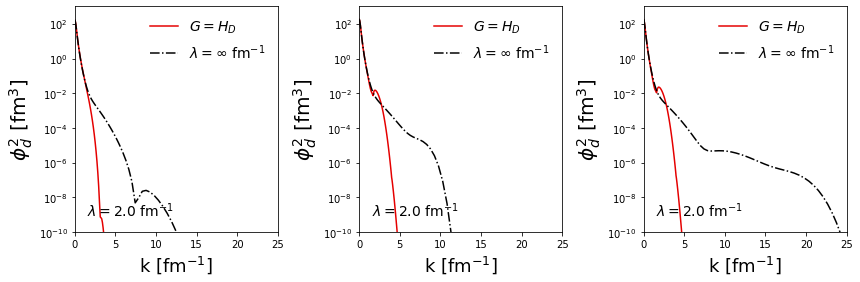

In [21]:
kvnns = [6, 901, 902]
f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, kvnn in enumerate(kvnns):
    deuteron_momentum_distribution(axes[i], kvnn, 30.0, 4.0, ntot, 2.0, 'Wegner')
    axes[i].set_xlim([0,25])
    axes[i].set_ylim([1e-10, 1e3])
# deuteron_momentum_distribution(ax1, 901, 30.0, 4.0, ntot, 2.0, 'Wegner')
# deuteron_momentum_distribution(ax2, 6, 30.0, 4.0, ntot, 2.0, 'Wegner')
# deuteron_momentum_distribution(ax3, 902, 30.0, 4.0, ntot, 2.0, 'Wegner')
#ax1.set_xlim([0, 6])
f.tight_layout()
#ax1.title('Lambda=9')

matplotlib.axes._subplots.AxesSubplot